In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]

In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data','derived','cleaned_matches.csv')
cleaned_matches = pd.read_csv(data)

In [3]:
cleaned_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Day             26122 non-null  object 
 1   Date            26122 non-null  object 
 2   Home/Away       26122 non-null  object 
 3   Opponent        26122 non-null  object 
 4   Score           26122 non-null  object 
 5   W/L/T           26122 non-null  object 
 6   Overtime        948 non-null    object 
 7   Location        26122 non-null  object 
 8   Venue           26122 non-null  object 
 9   Attendance      26098 non-null  float64
 10  Notes           1061 non-null   object 
 11  Opponent Code   26122 non-null  object 
 12  Team            26122 non-null  object 
 13  Team Code       26122 non-null  object 
 14  Team Score      25942 non-null  float64
 15  Opponent Score  25942 non-null  float64
 16  Score Sum       25942 non-null  float64
 17  Score Diff      25942 non-null 

## Train to regress on the difference of scores

In [4]:
x_cols = [
  'Team Code',
  'Opponent Code',
]
y_cols = [
  'Score Diff'
]

played_matches = cleaned_matches.dropna(axis=0, how='any', subset=x_cols + y_cols)

X = pd.concat([pd.get_dummies(played_matches[xcol],prefix='_'.join(xcol.split())+'_') for xcol in x_cols], axis=1)
y = played_matches[y_cols]


In [5]:
nas = ~y.notna()
y[~y.notna()]

,Score Diff
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
26117,NaN
26118,NaN
26119,NaN
26120,NaN


In [6]:
X[nas]

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Opponent_Code__nyj,Opponent_Code__oak,Opponent_Code__phi,Opponent_Code__pit,Opponent_Code__sd,Opponent_Code__sea,Opponent_Code__sf,Opponent_Code__stl,Opponent_Code__tb,Opponent_Code__was
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
  X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=0
)

y_train=y_train.ravel()
y_test=y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20753, 62) (20753,)
(5189, 62) (5189,)


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\an

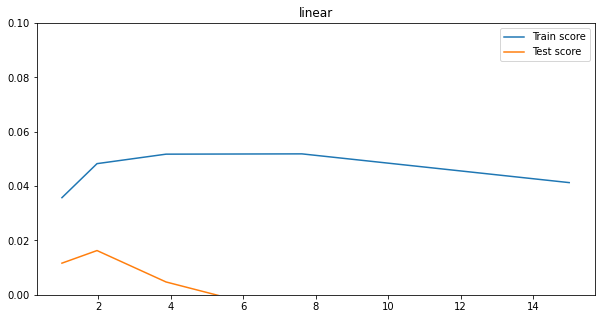

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\an

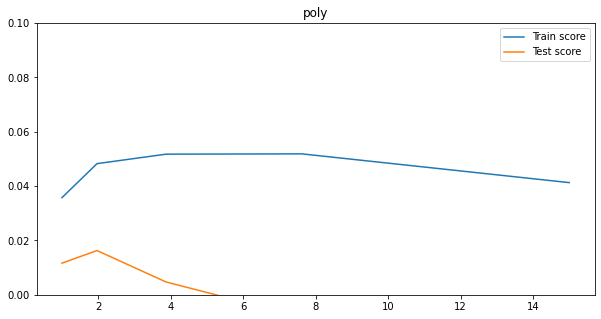

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\an

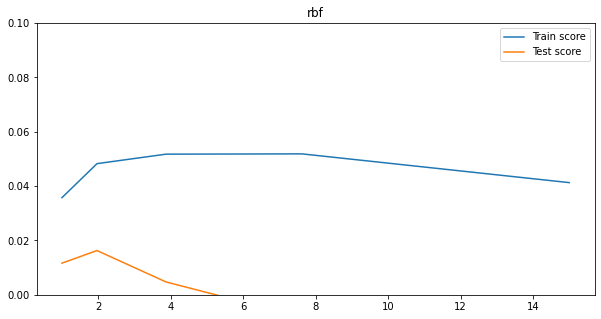

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
C:\Users\Eric\an

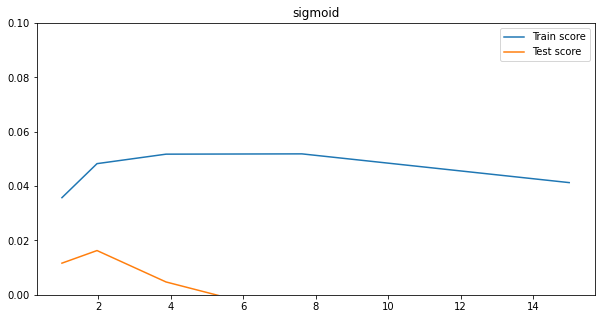

In [8]:
for kernel in ['linear', 'poly','rbf','sigmoid']:
  train_scores = []
  test_scores = []
  test_space = np.geomspace(start=1, stop=15, num=5)
  for C in test_space:
    model = pipeline.make_pipeline(
      preprocessing.StandardScaler(),
      svm.SVR(C=C,max_iter=10_000,kernel=kernel),
    )

    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

  plt.title(kernel)
  plt.plot(test_space, train_scores, label='Train score')
  plt.plot(test_space, test_scores, label='Test score')
  plt.ylim(0, 0.1)
  plt.legend()
  plt.show()